In [43]:
import numpy as np
import scipy.io
from matplotlib import mlab
import matplotlib.pyplot as plt
import scipy.signal
from mne.decoding import CSP
import mne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# 会导致许多维度的复杂  从而使代码复杂
m = scipy.io.loadmat('C:\\Users\\24242\\Desktop\\AI_Reference\\data_bag\\BCICIV\\BCICIV_calib_ds1b.mat',struct_as_record=True)

In [3]:
m

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jul  7 18:45:47 2008',
 '__version__': '1.0',
 '__globals__': [],
 'mrk': array([[(array([[  2085,   2885,   3685,   4485,   5285,   6085,   6885,   7685,
                   8485,   9285,  10085,  10885,  11685,  12485,  13285,  16286,
                  17086,  17886,  18687,  19486,  20286,  21086,  21886,  22686,
                  23486,  24286,  25086,  25886,  26686,  27486,  30487,  31287,
                  32087,  32887,  33687,  34487,  35287,  36087,  36887,  37687,
                  38487,  39287,  40087,  40887,  41687,  44688,  45488,  46288,
                  47088,  47888,  48688,  49488,  50288,  51088,  51888,  52688,
                  53488,  54288,  55088,  55888,  58887,  59687,  60487,  61287,
                  62087,  62887,  63687,  64487,  65287,  66087,  66887,  67687,
                  68487,  69287,  70087,  73088,  73888,  74688,  75488,  76288,
                  77088,  77888,  78688,  7

In [4]:
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [5]:
# 获取采样率
sample_rate = m['nfo']['fs'][0][0][0][0]
sample_rate

100

In [6]:
EEG = m['cnt'].T
EEG

array([[ -105,  -917, -2198, ...,  1250,  1264,  1246],
       [  -52,  -456, -1086, ...,  1834,  1867,  1846],
       [  -37,  -335,  -822, ...,   522,   534,   508],
       ...,
       [  -20,  -173,  -395, ...,  1961,  1996,  2032],
       [  -21,  -172,  -388, ...,  1474,  1473,  1418],
       [  -19,  -155,  -340, ...,  1862,  1877,  1924]], dtype=int16)

In [7]:
n_channels, n_samples = EEG.shape

In [8]:
channel_name = [s[0] for s in m['nfo']['clab'][0][0][0]]
channel_name

['AF3',
 'AF4',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'CFC7',
 'CFC5',
 'CFC3',
 'CFC1',
 'CFC2',
 'CFC4',
 'CFC6',
 'CFC8',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'CCP7',
 'CCP5',
 'CCP3',
 'CCP1',
 'CCP2',
 'CCP4',
 'CCP6',
 'CCP8',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'PO1',
 'PO2',
 'O1',
 'O2']

In [9]:
# 提取事件对应发生的时间
event_onsets = m['mrk'][0][0][0]
# 提取事件的编码 每个类别都对应了其编码  1代表着左手运动想象 -1代表着双脚 
event_codes = m['mrk'][0][0][1]

In [10]:
# 总有两百个数据  便于我们对连续的数据集事件编码进行分类
event_codes.shape

(1, 200)

In [11]:
# 创造一个0填充的矩阵
labels = np.zeros((1,n_samples),int)
labels

array([[0, 0, 0, ..., 0, 0, 0]])

In [12]:
# 将事件发生对应的事件进行标记编码  理解为当作是一个trigger触发条件
labels[0,event_onsets] = event_codes

In [13]:
# 提取事件的名称 二分类任务
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl_lab_left = cl_lab[0]
cl_lab_foot = cl_lab[1]

In [14]:
cl_lab_foot,cl_lab_left

('right', 'left')

In [15]:
# 到底有多少类
n_classes = len(cl_lab)
# 到底有多少个事件
nevents = len(event_onsets)

In [16]:
# 目前我们得到了我们基本需要的数据了
print('Shape of EEG:',EEG.shape)
print('Sample rate:',sample_rate)
print('Number of channels:',n_channels)
print('Channel names:',channel_name)
print('Number of events:',len(event_onsets))
print('Event codes:',np.unique(event_codes))
print('Number of classes:',n_classes)
print('Number of events:',nevents)

Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Number of classes: 2
Number of events: 1


In [17]:
# 将EEG从连续的信号中分离出来
trials = {}
# 定义时间窗口  这里是以0.5-2.5秒为单位的时间窗口
window = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))

In [18]:
# 再时间窗口上的样本 就是为200个数据点
nsamples = len(window)

In [19]:
for cl, code in zip(cl_lab,np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    
    trials[cl] = np.zeros((n_channels,nsamples,len(cl_onsets)))
    
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:,window+onset]

In [20]:
trials[cl_lab_foot].shape,trials[cl_lab_left].shape

((59, 200, 100), (59, 200, 100))

In [21]:
trials

{'left': array([[[ 449.,  488.,  590., ...,  946.,  743.,  727.],
         [ 446.,  463.,  589., ..., 1004.,  769.,  742.],
         [ 447.,  477.,  630., ..., 1026.,  724.,  734.],
         ...,
         [ 147.,  348.,  668., ...,  975.,  967.,  641.],
         [ 148.,  353.,  669., ..., 1030.,  949.,  590.],
         [ 141.,  366.,  653., ..., 1010.,  897.,  717.]],
 
        [[  74.,   30., -179., ...,  279.,  250., -158.],
         [  75.,    2., -167., ...,  303.,  258., -189.],
         [  71.,    6., -122., ...,  284.,  265., -156.],
         ...,
         [-134.,  -49.,  -11., ...,  376.,  470., -117.],
         [-137.,  -71.,  -16., ...,  376.,  465., -188.],
         [-138.,  -58.,   20., ...,  421.,  433.,  -98.]],
 
        [[ 352.,  312.,  474., ...,  992.,  643.,  633.],
         [ 342.,  269.,  460., ..., 1056.,  666.,  582.],
         [ 338.,  281.,  476., ..., 1056.,  640.,  656.],
         ...,
         [ 231.,  346.,  617., ...,  984.,  806.,  566.],
         [ 235.,

In [22]:
# 进行频谱图的绘制
def get_psd(trials):
    """
    计算出实验的PSD
    :param trials: 3d-array(channels,samples,trials)
    :return: trials_PSD:3d-array(channels,sample,trials)
             freqs:list of floats
    """
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((n_channels,101,ntrials))
    
    for trial in range(ntrials):
        for ch in range(n_channels):
            # 计算PSD 每个通道的
            (PSD,freqs) = mlab.psd(trials[ch,:,trial],NFFT=int(nsamples),Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    return trials_PSD,freqs

In [23]:
# 绘制PSD图
def plot_psd(trials_PSD,freqs,chan_ind,chan_lab=None,maxy=None):
    """
    plot PSD data
    :param trials_PSD:The PSD Data as returned by get_psd() 
    :param freqs: list of float as returned by get_psd()
    :param chan_ind: The indices of the channels to plot
    :param chan_lab: (optional)list of names for each channel
    :param maxy: (optional)Limit the y-axis to this value
    :return: None
    """
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    nrows = np.ceil(nchans/3)
    ncols = min(3,nchans)
    
    # Enumerate所有的通道
    for i,ch in enumerate(chan_ind):
        plt.subplot(int(nrows),ncols,i+1)
        
        for cl in trials.keys():
            plt.plot(freqs,np.mean(trials_PSD[cl][ch,:,:],axis=-1),label=cl)
        # 所有绘图的下方装饰
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
        else:
            plt.title(chan_lab[i])
        plt.grid()
        
        plt.xlabel('Frequency (HZ)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])
            
        plt.legend()
        
    plt.tight_layout()
    plt.show()

In [24]:
psd_left,freqs = get_psd(trials[cl_lab_left])
psd_foot,freqs = get_psd(trials[cl_lab_foot])
trials_PSD = {cl_lab_left:psd_left,cl_lab_foot:psd_foot}

In [25]:
trials.keys()

dict_keys(['left', 'right'])

In [26]:
freqs*100

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000., 2050., 2100., 2150., 2200.,
       2250., 2300., 2350., 2400., 2450., 2500., 2550., 2600., 2650.,
       2700., 2750., 2800., 2850., 2900., 2950., 3000., 3050., 3100.,
       3150., 3200., 3250., 3300., 3350., 3400., 3450., 3500., 3550.,
       3600., 3650., 3700., 3750., 3800., 3850., 3900., 3950., 4000.,
       4050., 4100., 4150., 4200., 4250., 4300., 4350., 4400., 4450.,
       4500., 4550., 4600., 4650., 4700., 4750., 4800., 4850., 4900.,
       4950., 5000.])

In [27]:
trials_PSD

{'left': array([[[9.65841046e+04, 2.25672330e+05, 4.88485157e+05, ...,
          1.58392422e+06, 7.30285204e+05, 6.19557687e+05],
         [4.87281368e+04, 1.07303642e+05, 2.56995190e+05, ...,
          8.28924091e+05, 3.62984503e+05, 3.03877834e+05],
         [1.71612413e+00, 3.48687354e+02, 1.76831414e+02, ...,
          2.63356024e+02, 2.15195716e+02, 5.99388259e+02],
         ...,
         [1.39956795e-04, 4.89577029e-04, 3.98301013e-04, ...,
          2.04812325e-03, 4.32500518e-03, 3.05666936e-03],
         [1.54042287e-03, 1.82933498e-04, 4.84252040e-04, ...,
          2.20511567e-03, 4.14552842e-03, 5.39492084e-03],
         [2.73705358e-03, 2.55993099e-05, 1.29910580e-03, ...,
          9.60400281e-05, 4.31062976e-03, 6.06332095e-03]],
 
        [[1.97992170e+03, 2.54878394e+01, 2.61395654e+04, ...,
          2.23358712e+05, 1.03152682e+05, 2.50895073e+04],
         [1.25484693e+03, 2.92141528e+02, 1.59857903e+04, ...,
          1.21771932e+05, 5.11653479e+04, 1.53636233e+04],

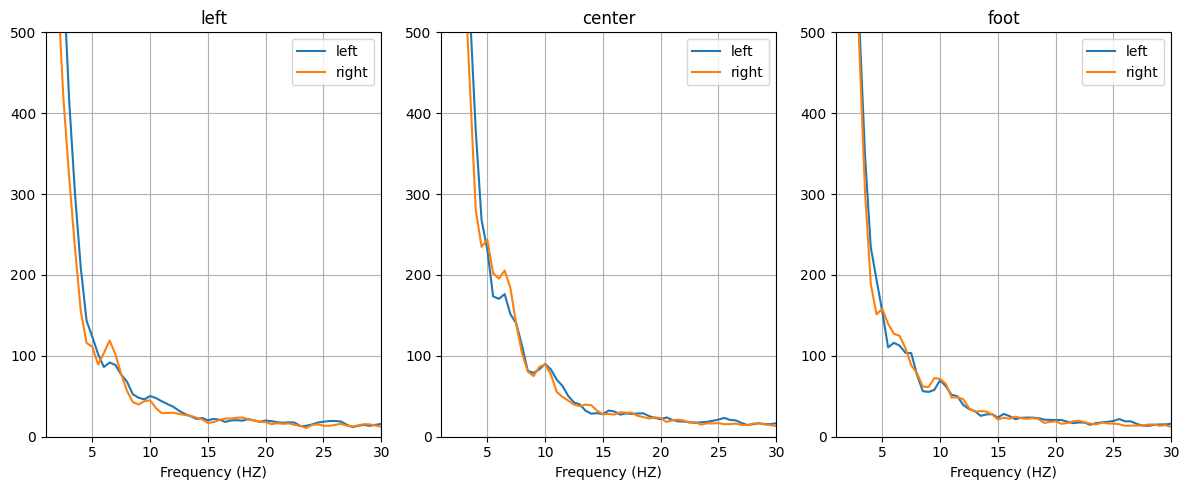

In [28]:
# 我们选择Cz C3 C4三个通道进行绘制 C3代表着左边 C4代表着右边（但是本次我们用的是双脚） Cz代表着中间
plot_psd(trials_PSD,freqs,[channel_name.index(ch) for ch in ['C3','Cz','C4']],chan_lab=['left','center','foot'],maxy=500)

In [29]:
"""
我们都直到左手运动是右脑 右手运动是左脑 脚步运动是由脑部的中央片区控制的
"""

'\n我们都直到左手运动是右脑 右手运动是左脑 脚步运动是由脑部的中央片区控制的\n'

In [30]:
# 尝试创建一下raw对象
info = mne.create_info(ch_names=channel_name,sfreq=100,ch_types='eeg')

raw = mne.io.RawArray(EEG,info)

print(raw)

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
<RawArray | 59 x 190594 (1905.9 s), ~85.9 MB, data loaded>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


C:\Users\24242\AppData\Local\Temp\ipykernel_24124\2093185488.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
C:\Users\24242\PycharmProjects\pythonProject\venv\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


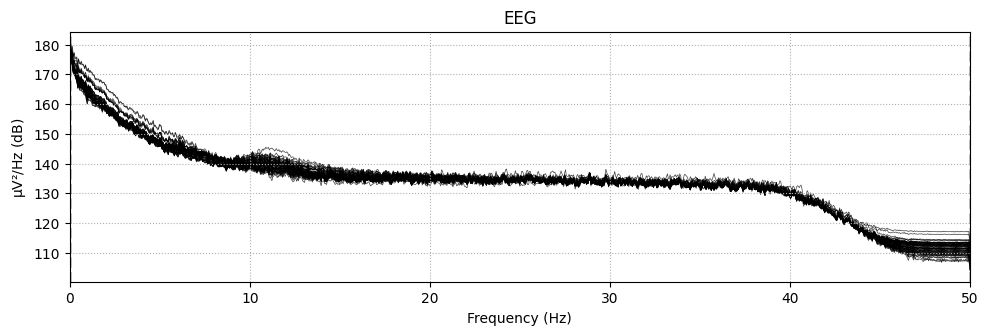

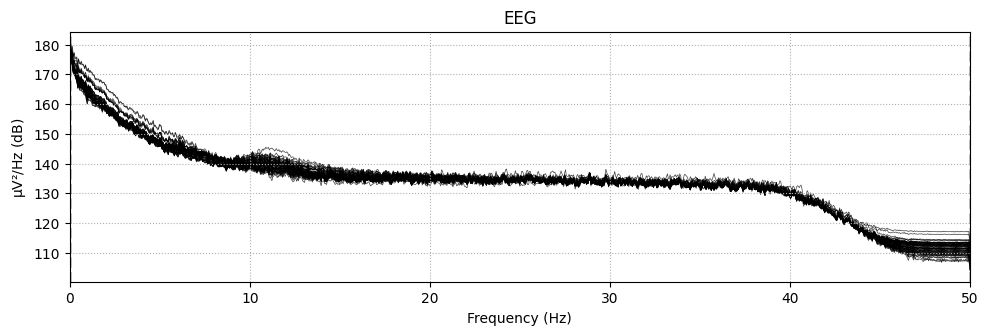

In [31]:
raw.plot_psd()

In [32]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>

In [33]:
raw.get_data()

array([[ -105.,  -917., -2198., ...,  1250.,  1264.,  1246.],
       [  -52.,  -456., -1086., ...,  1834.,  1867.,  1846.],
       [  -37.,  -335.,  -822., ...,   522.,   534.,   508.],
       ...,
       [  -20.,  -173.,  -395., ...,  1961.,  1996.,  2032.],
       [  -21.,  -172.,  -388., ...,  1474.,  1473.,  1418.],
       [  -19.,  -155.,  -340., ...,  1862.,  1877.,  1924.]])

In [34]:
# 创建带通滤波器
def bandpass(trials, lo, hi, sample_rate):
    # IIRfilter滤波器设置  第一个参数为过滤器顺序 第二个参数为临界的标量 为半个周期所以是采样率/2 既是sample_rate/2
    a,b = scipy.signal.iirfilter(6,[lo/(sample_rate/2.0),hi/(sample_rate/2.0)])
    ntrials = trials.shape[2]
    trials_filt = np.zeros((n_channels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
        
    return trials_filt

In [35]:
# 进行滤波处理 就像mne包中Epoch.get_data().filter()一样 默认是FIR
trials_filt = {cl_lab_left:bandpass(trials[cl_lab_left],8,15,sample_rate),
               cl_lab_foot:bandpass(trials[cl_lab_foot],8,15,sample_rate)}

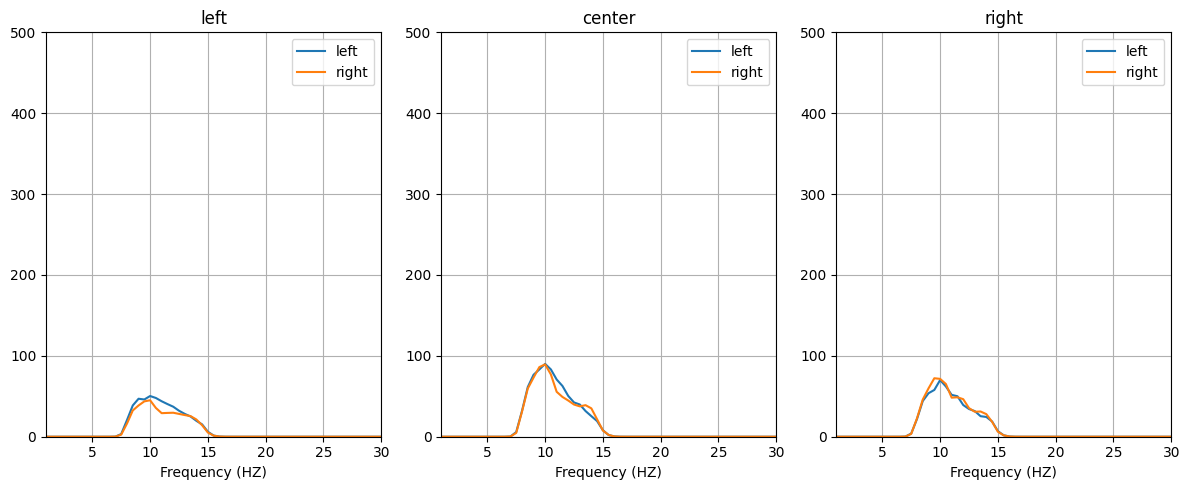

In [36]:
# 只选择8，15该频率观察后
psd_left,freqs = get_psd(trials_filt[cl_lab_left])
psd_foot,freqs = get_psd(trials_filt[cl_lab_foot])
trials_PSD = {cl_lab_left:psd_left,cl_lab_foot:psd_foot}

plot_psd(
    trials_PSD,
    freqs,
    [channel_name.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=500
)

In [37]:
# 取信号的对数方差
def logvar(trials):
    return np.log(np.var(trials,axis=1))

In [38]:
trials_logvar = {cl_lab_left:logvar(trials_filt[cl_lab_left]),
                 cl_lab_foot:logvar(trials_filt[cl_lab_foot])}

In [39]:
# 绘制每个通道的对数方差
def plot_logvar(trials):
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(n_channels)
    x1 = np.arange(n_channels) + 0.4
    
    y0 = np.mean(trials[cl_lab_left],axis=1)
    y1 = np.mean(trials[cl_lab_foot],axis=1)
    
    plt.bar(x0,y0,width=0.5,color='b')
    plt.bar(x1,y1,width=0.4,color='r')
    
    plt.xlim(-0.5,n_channels+0.5)
    
    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channel/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

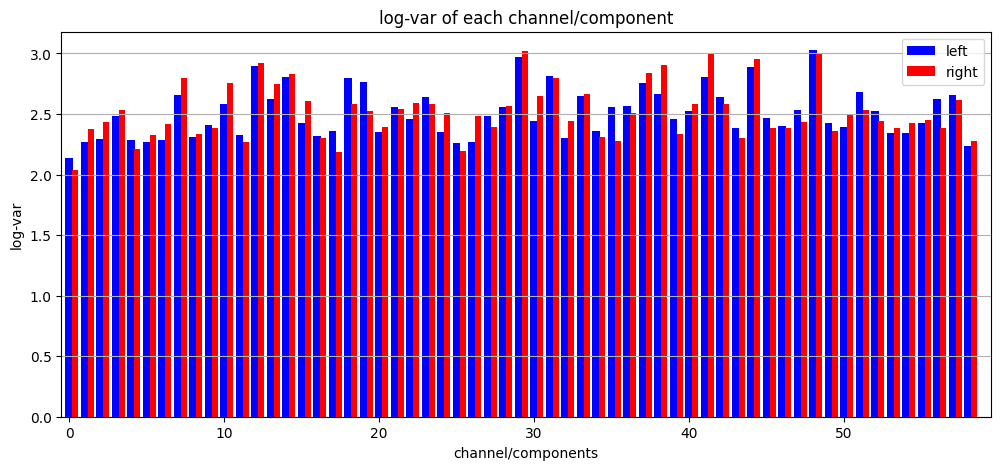

In [57]:
plot_logvar(trials_logvar)

In [58]:
# 调用共空间模式
def cov(trials):
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T)/nsamples for i in range(ntrials)]
    return np.mean(covs,axis=0)

In [59]:
# 矩阵的白化
def whitening(sigma):
    u,l,_ = np.linalg.svd(sigma)
    return u.dot(np.diag(l**-0.5))

In [60]:
# 构建csp滤波器
def csp(trials_l,trials_r):
    cov_l = cov(trials_l)
    cov_r = cov(trials_r)
    # 进行矩阵的白化操作
    p = whitening(cov_l + cov_r)
    B,_,_ = np.linalg.svd(p.T.dot(cov_r).dot(p))
    W = p.dot(B)
    return W

In [61]:
# 进行滤波处理后方差最大化数据
def apply_mix(W,trials):
    ntrials = trials.shape[2]
    trials_csp = np.zeros((n_channels,nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [64]:
W = csp(trials_filt[cl_lab_left],trials_filt[cl_lab_foot])
trials_csp = {cl_lab_left:apply_mix(W,trials_filt[cl_lab_left]),
              cl_lab_foot:apply_mix(W,trials_filt[cl_lab_foot])}


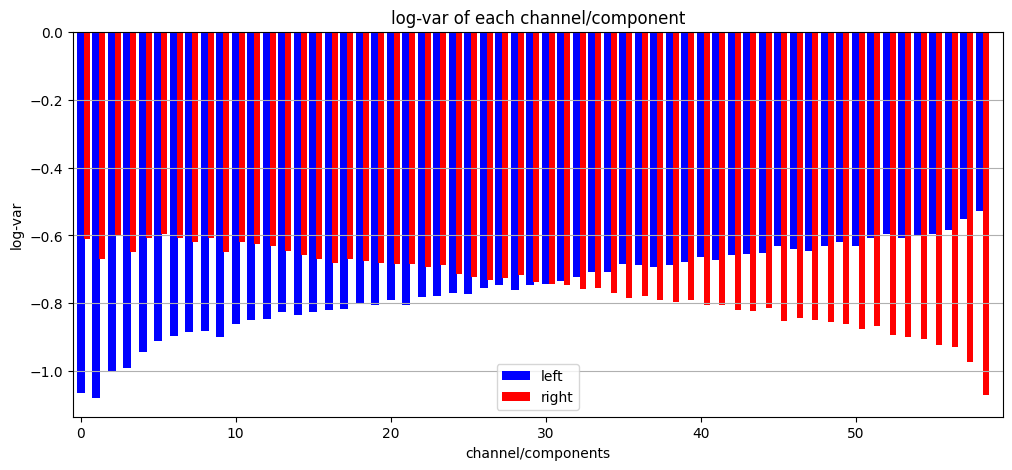

In [65]:
trials_logvar = {cl_lab_left:logvar(trials_csp[cl_lab_left]),
                 cl_lab_foot:logvar(trials_csp[cl_lab_foot])}
plot_logvar(trials_logvar)

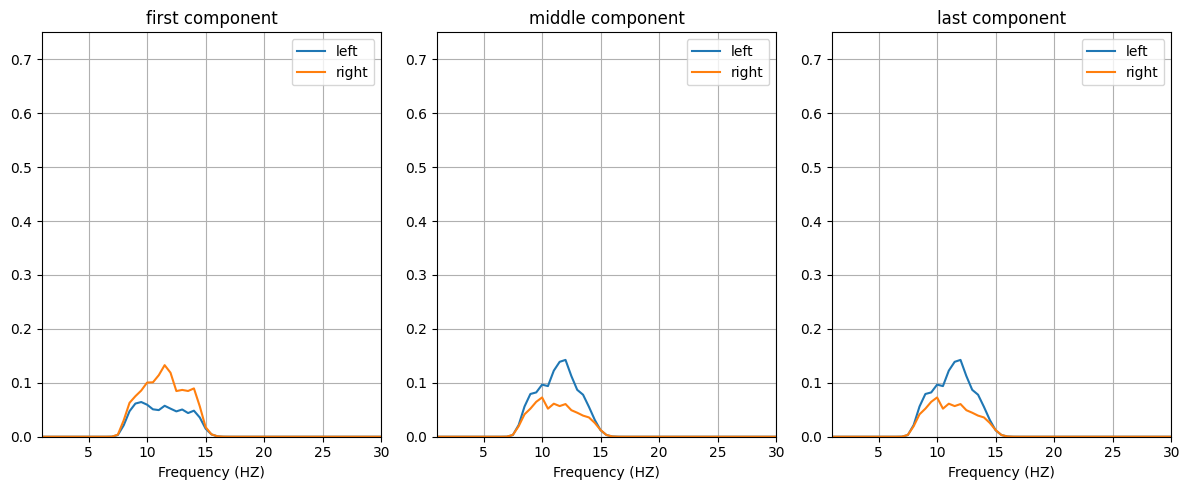

In [66]:
psd_l,freqs = get_psd(trials_csp[cl_lab_left])
psd_r,freqs = get_psd(trials_csp[cl_lab_foot])
trials_PSD = {cl_lab_left:psd_l,cl_lab_foot:psd_r}

plot_psd(trials_PSD,freqs,[0,58,-1],chan_lab=['first component','middle component','last component'],maxy=0.75)

In [67]:
# 画出经过csp方法处理后使两类差异最大化的散点图
def plot_scatter(left,right):
    plt.figure()
    # 将第一维度中的第一行作为x  最后一行作为y进行散点图的绘制 这也是一直没搞清楚绘图原理的原因
    plt.scatter(left[0,:],left[-1,:],color='b')
    plt.scatter(right[0,:],right[-1,:],color='r')
    plt.xlabel('Last component')
    plt.xlabel('First component')
    plt.legend(cl_lab)

In [72]:
# 观察一下数据
print(trials_logvar[cl_lab_left][0, :])
print(trials_logvar[cl_lab_left][-1,:])

[-1.57844825 -0.79490859 -0.99161635 -0.81268313 -1.10078543 -0.85423085
 -1.2759451  -1.00793266 -1.46489721 -0.83736527 -1.31370915 -1.21495193
 -1.35927397 -0.76311196 -1.41929179 -1.34371882 -1.91043187 -1.07254115
 -1.2288778  -1.8256277  -0.70372243 -1.51449231 -0.99056808 -0.94231625
 -0.7858925  -1.10404938 -1.49572378 -1.61095118 -1.27263114 -1.13891002
 -0.69370295 -1.21878554 -1.76643912 -0.83503063 -1.05766607 -1.37321773
 -1.44456638 -1.02674931 -1.71619644 -1.54337542 -0.77266714 -1.40503826
 -1.17060335 -1.61406241 -1.26144652 -1.15869138 -1.01735067 -1.23527218
 -1.12341532 -1.65615295 -0.57203402 -0.81421788 -1.34797771 -1.89915707
 -1.20512852 -1.26730164 -1.34673792 -0.82993406 -1.1992756  -1.32937918
 -0.97972119 -1.24623356 -1.299566   -0.81321422 -1.76416249 -1.38944885
 -0.98921924 -0.78088384 -0.91278053 -1.2206885  -1.0798252  -1.34636069
 -0.3623441  -0.55065206 -0.38870187 -0.46007278 -0.86607894 -0.88378888
 -0.50101334 -1.17588514 -1.03316101 -0.97927279 -0

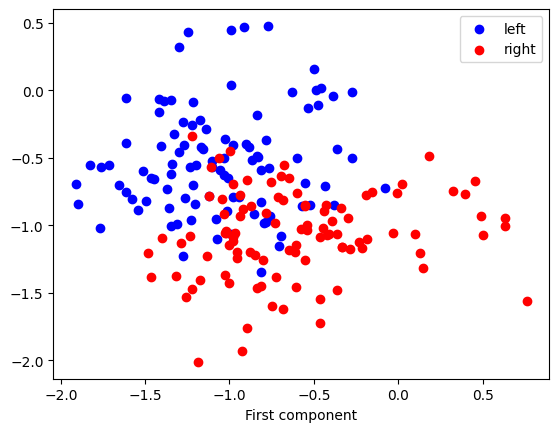

In [68]:
plot_scatter(trials_logvar[cl_lab_left],trials_logvar[cl_lab_foot])

In [81]:
# 进行数据清洗  用滤波后的数据分出训练集和测试集
train_percentage = 0.5

ntrain_l = int(trials_filt[cl_lab_left].shape[2]*train_percentage)
ntrain_r = int(trials_filt[cl_lab_foot].shape[2]*train_percentage)

ntest_l = trials_filt[cl_lab_left].shape[2] - ntrain_l
ntest_r = trials_filt[cl_lab_foot].shape[2] - ntrain_r

train = {cl_lab_left:trials_filt[cl_lab_left][:,:,:ntrain_l],
         cl_lab_foot:trials_filt[cl_lab_foot][:,:,:ntrain_r]}
test = {cl_lab_left:trials_filt[cl_lab_left][:,:,ntrain_l:],
        cl_lab_foot:trials_filt[cl_lab_foot][:,:,ntrain_r:]}


In [82]:
# 得到训练集和测试集数据的滤波器
W = csp(train[cl_lab_left],train[cl_lab_foot])

In [84]:
train[cl_lab_left].shape,train[cl_lab_foot].shape,W.shape

((59, 200, 50), (59, 200, 50), (59, 59))

In [85]:
train[cl_lab_left] = apply_mix(W,train[cl_lab_left])
train[cl_lab_foot] = apply_mix(W,train[cl_lab_foot])
test[cl_lab_left] = apply_mix(W,test[cl_lab_left])
test[cl_lab_foot] = apply_mix(W,test[cl_lab_foot])

In [86]:
train[cl_lab_left].shape,train[cl_lab_foot].shape

((59, 200, 50), (59, 200, 50))

In [87]:
# 定义两个组件0和-1 也就是第一行数据和最后一行数据得到两个组件
component = np.array([0,-1])
train[cl_lab_left] = train[cl_lab_left][component,:,:]
train[cl_lab_foot] = train[cl_lab_foot][component,:,:]
test[cl_lab_left] = test[cl_lab_left][component,:,:]
test[cl_lab_foot] = test[cl_lab_foot][component,:,:]

In [88]:
# 显示出我们有两个组件
train[cl_lab_left].shape,train[cl_lab_foot].shape

((2, 200, 50), (2, 200, 50))

In [89]:
train[cl_lab_left] = logvar(train[cl_lab_left])
train[cl_lab_foot] = logvar(train[cl_lab_foot])
test[cl_lab_left] = logvar(test[cl_lab_left])
test[cl_lab_foot] = logvar(test[cl_lab_foot])

In [90]:
train[cl_lab_left].shape,train[cl_lab_foot].shape

((2, 50), (2, 50))

In [91]:
print(train[cl_lab_left])

[[-1.18874047e+00 -5.02639850e-01 -7.09146387e-01 -1.02473922e+00
  -6.33513264e-01 -1.33011843e+00 -7.03479018e-01 -9.62300910e-01
  -1.58837941e+00 -1.05674805e+00 -1.48943623e+00 -9.62586695e-01
  -1.44272012e+00 -9.71897673e-01 -1.06359084e+00 -6.20381572e-01
  -7.00703641e-01 -9.26907491e-01 -1.39705925e+00 -1.06275325e+00
  -7.92425376e-01 -1.17978099e+00 -5.97239621e-01 -8.30238223e-01
  -1.12823343e+00 -1.26350222e+00 -8.50117980e-01 -9.41970068e-01
  -1.09032203e+00 -1.44201434e+00 -6.83876438e-01 -9.77518284e-01
  -1.36012869e+00 -8.10133035e-01 -1.01824569e+00 -6.63107114e-01
  -1.21537830e+00 -1.06834485e+00 -1.08730635e+00 -1.63100182e+00
  -1.03394372e+00 -1.06277601e+00 -1.18532438e+00 -9.47083933e-01
  -1.69126431e+00 -1.33000639e+00 -1.16503842e+00 -1.23754565e+00
  -9.57044412e-01 -1.47150215e+00]
 [-5.62125916e-01 -1.15725095e+00 -9.87050017e-01 -8.42575479e-01
  -4.09349486e-01 -8.11690178e-01 -3.58070682e-01 -7.34188727e-01
  -5.16844736e-01 -2.45120955e-01 -5.7443

In [96]:
def train_lda(class1,class2):
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    prior1 = nclass1/float(nclass1+nclass2)
    prior2 = nclass2/float(nclass1+nclass1)
    
    mean1 = np.mean(class1,axis=0)
    mean2 = np.mean(class2,axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    cov1 = class1_centered.T.dot(class1_centered)/(nclass1-nclasses)
    cov2 = class2_centered.T.dot(class2_centered)/(nclass2-nclasses)
    
    W = (mean2-mean1).dot(np.linalg.pinv(prior1*cov1)+prior2*cov2)
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

In [97]:
def apply_lda(test,W,b):
    ntrials = test.shape[1]
    prediction = []
    for i in range(ntrials):
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
        
    return np.array(prediction)

In [98]:
# 得到权重和偏置项
W,b = train_lda(train[cl_lab_left].T,train[cl_lab_foot].T)

print('W',W)
print('b',b)

W [ 13.70309044 -10.76769052]
b -2.064986832473359


(-2.2, 1.0)

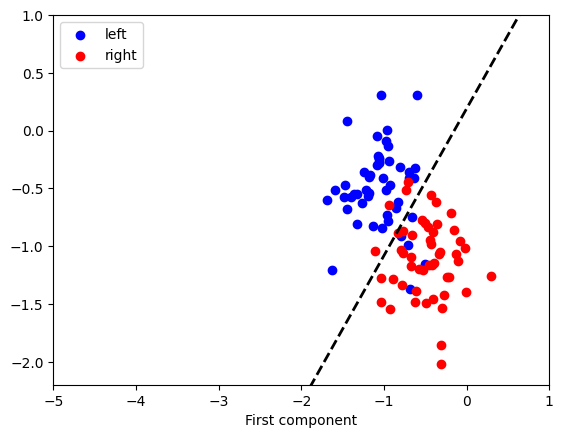

In [102]:
# 画出分类后的图像
plot_scatter(train[cl_lab_left],train[cl_lab_foot])

x = np.arange(-5,1,0.1)
y = (b-W[0]*x) / W[1]

plt.plot(x,y,linestyle='--',linewidth=2,color='k')
plt.xlim(-5,1)
plt.ylim(-2.2,1)

In [104]:
# 通过混淆矩阵减少错误的出现
conf = np.array([
    [(apply_lda(test[cl_lab_left],W,b) == 1).sum(),(apply_lda(test[cl_lab_foot],W,b) == 1).sum()],
    [(apply_lda(test[cl_lab_left],W,b) == 2).sum(),(apply_lda(test[cl_lab_foot],W,b) == 2).sum()],
])

print(conf)
print('Accuracy:%3.f' %(np.sum(np.diag(conf))/float(np.sum(conf))))

[[31 15]
 [19 35]]
Accuracy:  1
